# 1. Classification on `emnist` 

In [1]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown
# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
import xgboost as xgb
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier
# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings


In [2]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Modified to display heatmap for multiclass
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if not isinstance(value, np.ndarray):
            metrics_df[key] = [value]

    cm = metrics_dict[task][model_name]['confusion_matrix']
    cm_df = pd.DataFrame(cm / cm.sum(axis=1)[:, np.newaxis])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=False, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    # Customize axis labels
    plt.xticks(ticks=np.arange(62) + 0.5, labels=[str(i) if i < 10 else chr(i - 10 + ord('A')) if i < 36 else chr(i - 36 + ord('a')) for i in range(62)])
    plt.yticks(ticks=np.arange(62) + 0.5, labels=[str(i) if i < 10 else chr(i - 10 + ord('A')) if i < 36 else chr(i - 36 + ord('a')) for i in range(62)])
    plt.show()
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)

 

In [3]:
# Load Data - stratified subsampled 1/10

from sklearn.model_selection import train_test_split
 
random_seed = 42

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Stratified sampling to get 1/10 of the original data
train, _ = train_test_split(train, test_size=0.9, stratify=train['label'], random_state=random_seed)

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label
# same for valid
valid, _ = train_test_split(valid, test_size=0.9, stratify=valid['label'], random_state=random_seed)



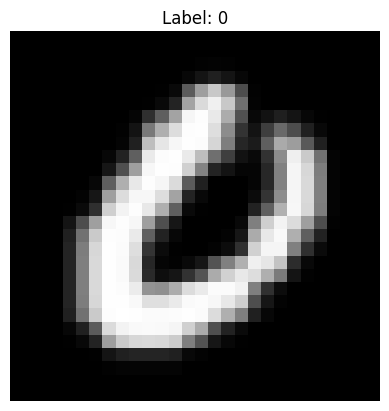

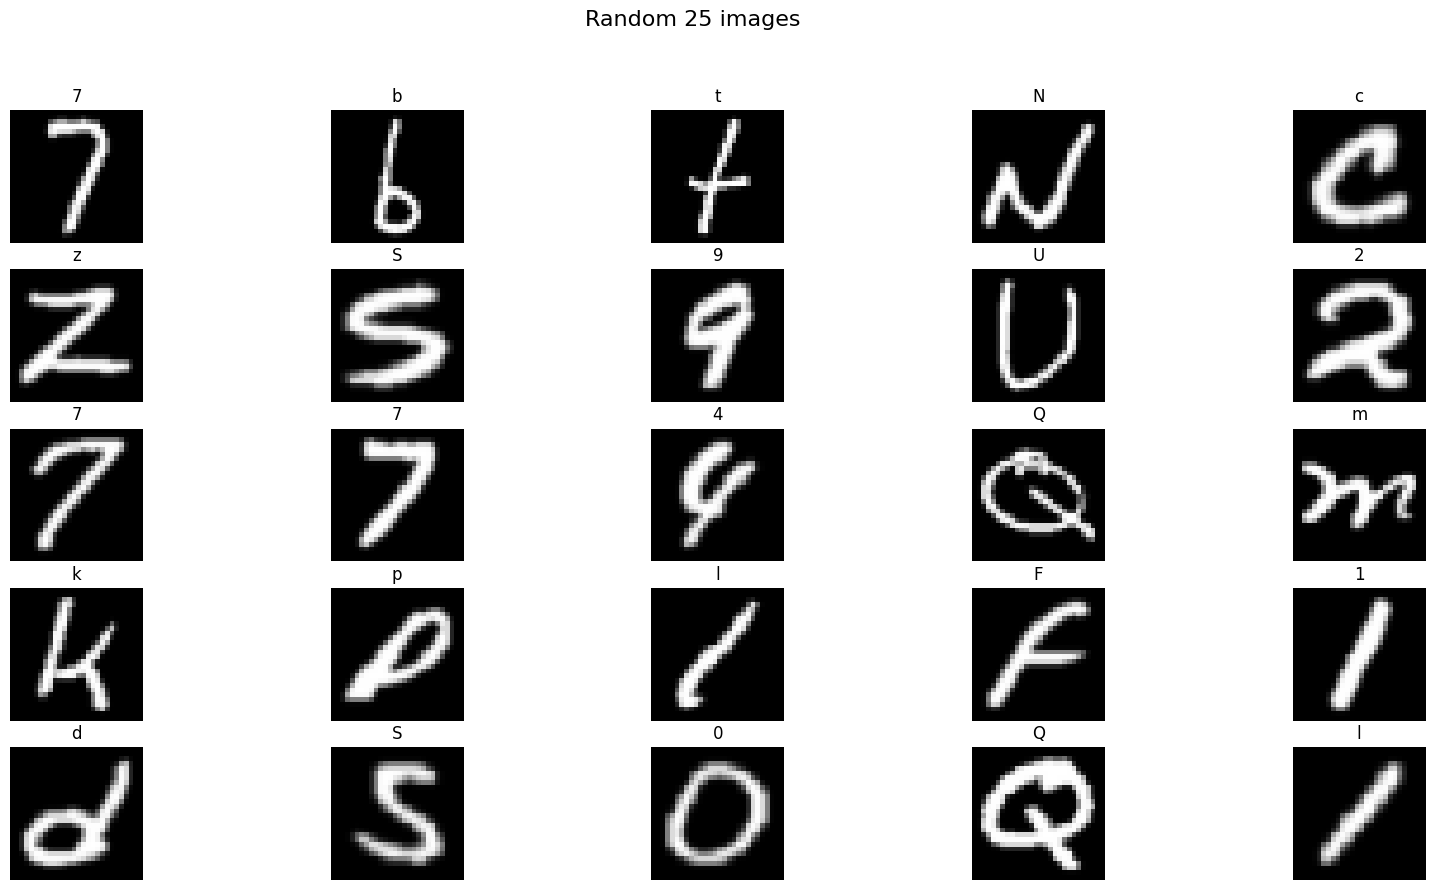

In [4]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?


In [16]:
# (OPTIONAL) We can define all the metrics we want to track in a dictionary
metrics_dict = {
    'multi-class' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [17]:
train.columns

Index(['image', 'image_flat', 'label', 'class'], dtype='object')

In [11]:
len(train.label.unique())

62

In [18]:
print(valid.shape)
print(train.shape)

(11632, 4)
(69793, 4)


## Regular w sklearn

### Training

In [ ]:
from sklearn.model_selection iport gradient

In [20]:
X_train = train['image_flat'].tolist()
y_train = train['label']
X_valid = valid['image_flat'].tolist()
y_valid = valid['label'] 

# define models
models = {
    'gradientboost': LogisticRegression(max_iter=100),
    'random_forest': RandomForestClassifier(n_estimators=100),
    'xgboost': xgb.XGBClassifier()
}

# iterate thru the list of models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='macro')
    recall = recall_score(y_valid, y_pred, average='macro')
    f1 = f1_score(y_valid, y_pred, average='macro')
    cm = confusion_matrix(y_valid, y_pred)
    
    metrics_dict['multi-class'][model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }


/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and be

### Performance

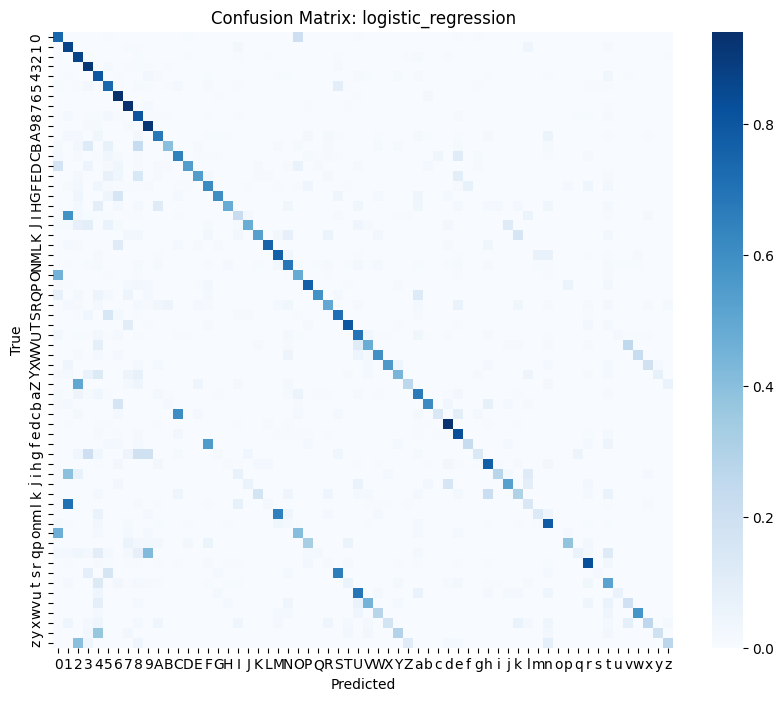

# Performance Metrics: logistic_regression

,accuracy,precision,recall,f1
0,0.709508,0.58451,0.534165,0.546261


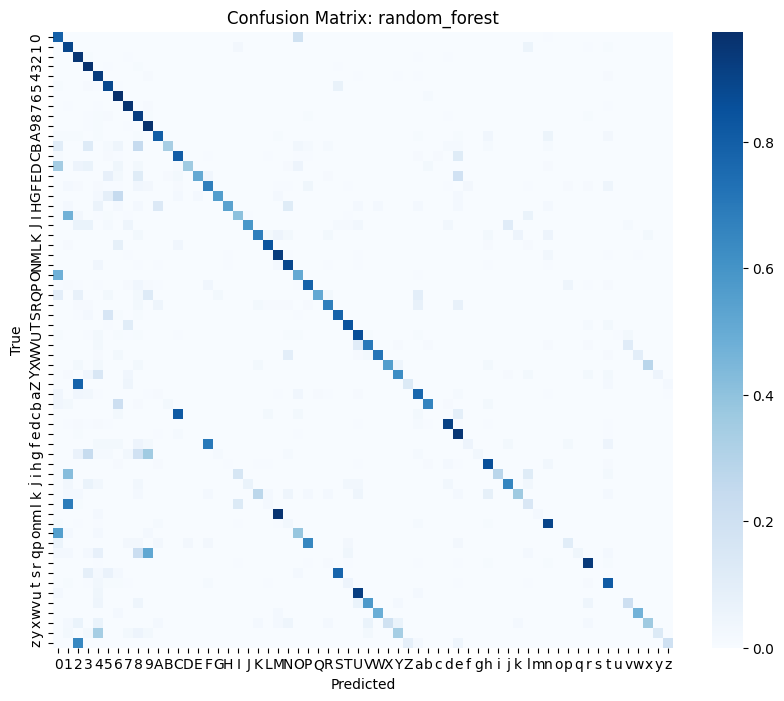

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.781379,0.698097,0.575645,0.594365


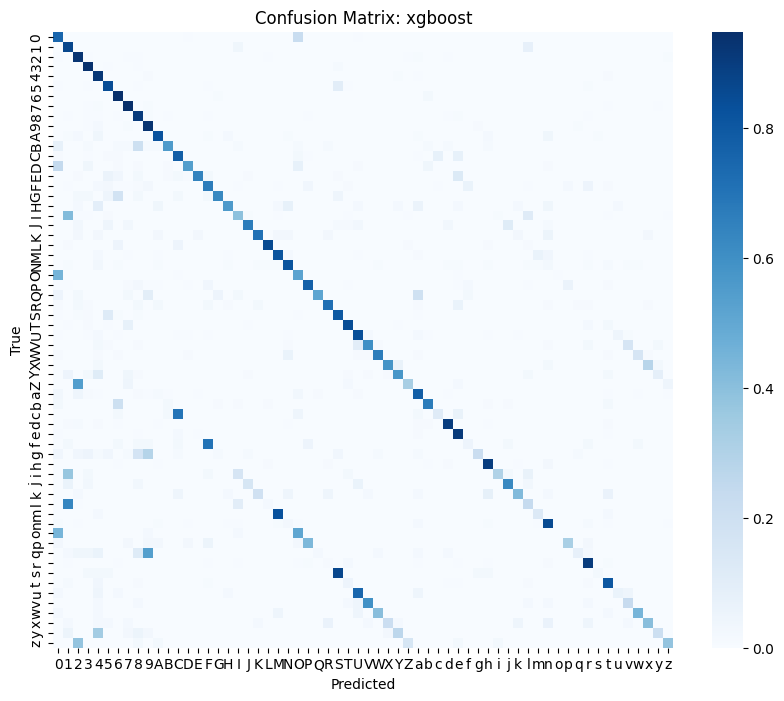

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.774845,0.662735,0.599033,0.615849


In [21]:

# Call the function for each model
for model_name in models:
    display_metrics('multi-class', model_name, metrics_dict)


## Nueral Net w TF

### Training

In [22]:
task = 'multi-class'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images = np.array(train['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train['label'])
valid_images = np.array(valid['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid['label'])
# Convert labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes=62)
valid_labels_onehot = to_categorical(valid_labels, num_classes=62)


# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(62, activation='softmax')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels_onehot, epochs=20, validation_data=(valid_images, valid_labels_onehot))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels_onehot) 
y_pred = np.argmax(model.predict(valid_images), axis=-1)


Epoch 1/20
2182/2182 [==============================] - 5s 2ms/step - loss: 0.9857 - accuracy: 0.7139 - val_loss: 0.7223 - val_accuracy: 0.7784
Epoch 2/20
2182/2182 [==============================] - 5s 2ms/step - loss: 0.6243 - accuracy: 0.7964 - val_loss: 0.6510 - val_accuracy: 0.7855
Epoch 3/20
2182/2182 [==============================] - 4s 2ms/step - loss: 0.5269 - accuracy: 0.8175 - val_loss: 0.6277 - val_accuracy: 0.7951
Epoch 4/20
2182/2182 [==============================] - 4s 2ms/step - loss: 0.4694 - accuracy: 0.8349 - val_loss: 0.6083 - val_accuracy: 0.7985
Epoch 5/20
2182/2182 [==============================] - 4s 2ms/step - loss: 0.4242 - accuracy: 0.8468 - val_loss: 0.6101 - val_accuracy: 0.8025
Epoch 6/20
2182/2182 [==============================] - 4s 2ms/step - loss: 0.3907 - accuracy: 0.8558 - val_loss: 0.6485 - val_accuracy: 0.7958
Epoch 7/20
2182/2182 [==============================] - 4s 2ms/step - loss: 0.3603 - accuracy: 0.8654 - val_loss: 0.6431 - val_accuracy:

### Performance

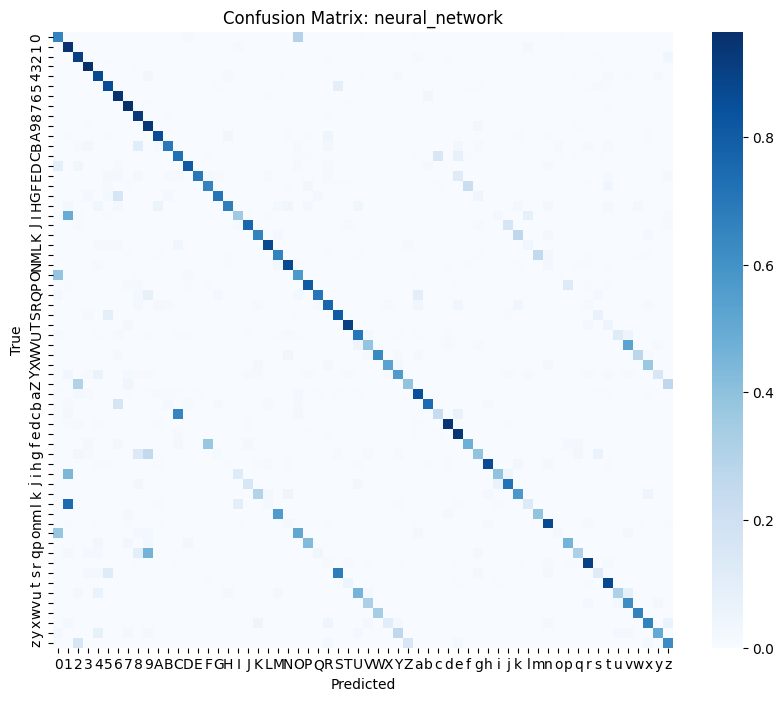

# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.794016,0.678527,0.666785,0.664774


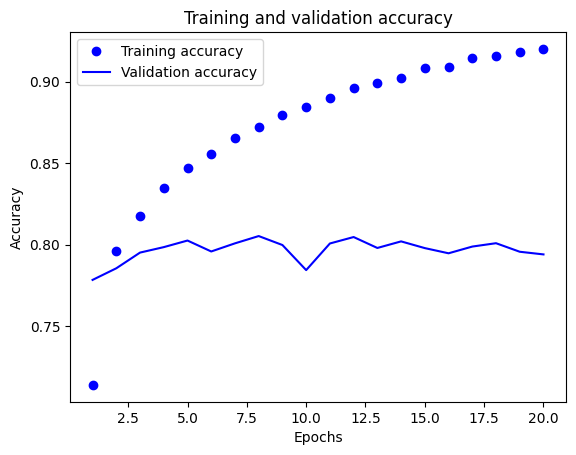

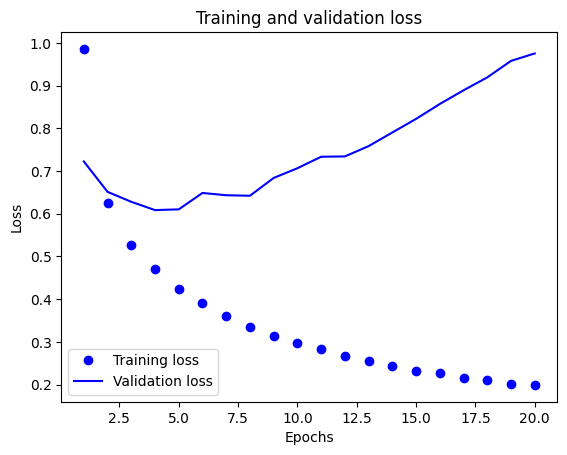

In [24]:

# Calculate performance metrics
prec = precision_score(valid_labels, y_pred, average='macro')
rec = recall_score(valid_labels, y_pred, average='macro')
f1 = f1_score(valid_labels, y_pred, average='macro')
cm = confusion_matrix(valid_labels, y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}
# confusion matrix
display_metrics(task, model_name, metrics_dict)
# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

The model achieves an average accuracy of 82.8 across different classes. From the heatmap, it seems the model fails at classifying between certain letters' upper and lowercases, for example, m-M, s-S, u-U, etc., which is reasonable considering they look similar. The training history shows that test (validation) performance does not increase beyond the 3rd epoch, while the training accuracy seems to be still increasing, deviating from the validation accuracy towards the 20th spoch. 

# 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:


## Prep
1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric: accuracy
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model to the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set 
8. Report model performance

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [5]:
# Load Data - stratified subsampled 1/10 from prev
 

train['is_digit'] = train['class'].apply(lambda x: x.isdigit())
valid['is_digit'] = valid['class'].apply(lambda x: x.isdigit())
 
train2, test = train_test_split(train, test_size=0.2, random_state=42, stratify=train['is_digit'])
 

In [6]:
 
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier()
}

results = {}
for model_name, model in models.items():
    accuracies = []
    for train_idx, test_idx in kfold.split(train2, train2['is_digit']):
        X_train_fold, X_test_fold = train2.iloc[train_idx]['image_flat'], train2.iloc[test_idx]['image_flat']
        y_train_fold, y_test_fold = train2.iloc[train_idx]['label'], train2.iloc[test_idx]['label']
        model.fit(X_train_fold.values.tolist(), y_train_fold)  # Converting to list as fit() expects array-like inputs
        y_pred_fold = model.predict(X_test_fold.values.tolist())
        accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
        accuracies.append(accuracy_fold)
    results[model_name] = np.mean(accuracies)

best_model = max(results, key=results.get)
selected_model = models[best_model]
selected_model.fit(train2['image_flat'].values.tolist(), train2['label'])  # Converting to list
y_pred_valid = selected_model.predict(valid['image_flat'].values.tolist())  # Converting to list
accuracy_valid = accuracy_score(valid['label'], y_pred_valid)

print("Performance of the selected model ({}):".format(best_model))
print("Accuracy on validation set:", accuracy_valid)


/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Performance of the selected model (Random Forest):
Accuracy on validation set: 0.7787138927097662
